# DL vertex input image generation

This notebook is designed to take CSV files generated by the <code>PrepareTrainingSample</code> function of the <code>DlVertexingAlgorithm</code>. This algorithm generates CSV files for each of the U. V and W views and the code below will run over each of those files.
    
Most of the cells below will not need any editing, but at the very bottom of the notebook you will find some additional markdown that describes what you may need to edit (essentially just some file locations).

In [1]:
# Automatically reload external libraries that change
%reload_ext autoreload
%autoreload 2

# If a matplotlib plot command is issued, display the results in the notebook
%matplotlib inline

In [2]:
wire_pitch = { "U": 0.300000011921, "V": 0.300000011921, "W": 0.300000011921 }
drift_step = 0.3

def make_input_histogram(x, z, adc, pdg, nu_like, cr_like, vertex, x_bounds, z_bounds, image_size, view):
    global thresholds
    image_height, image_width = image_size
    x_min, x_max = x_bounds
    z_min, z_max = z_bounds
    
    # Update the span if image is too small
    r_span = np.sqrt((x_max - x_min)**2 + (z_max - z_min)**2)
    
    x_bins = np.linspace(x_min - 0.5 * drift_step, x_max + 0.5 * drift_step, image_width + 1)
    z_bins = np.linspace(z_min - 0.5 * wire_pitch[view], z_max + 0.5 * wire_pitch[view], image_height + 1)
    
    phx = np.digitize(x, x_bins) - 1
    phx = np.clip(phx, 0, image_width - 1)
    phz = np.digitize(z, z_bins) - 1
    phz = np.clip(phz, 0, image_height - 1)
    pha = np.digitize(adc, z_bins) - 1
        
    pvx = np.digitize(vertex[0], x_bins) - 1
    pvz = np.digitize(vertex[1], z_bins) - 1

    input_histogram, _, _ = np.histogram2d(z, x, bins=[z_bins, x_bins], weights=adc)
    input_histogram = input_histogram.astype(float) 
    
    input_nu_histogram = np.zeros_like(input_histogram)
    input_nu_histogram = input_histogram.astype(float)

    input_cr_histogram = np.zeros_like(input_histogram)
    input_cr_histogram = input_histogram.astype(float)

    # Fill both manually, we don't want any binning/averaging.
    for i in range(len(phx)):
        input_nu_histogram[phz[i], phx[i]] = nu_like[i]
        input_cr_histogram[phz[i], phx[i]] = cr_like[i]

    # ATTN: Need to set the dtype here or truth will be of type 8-bit uint before scaling, which will result in
    # incorrect distances for dr > 255
    truth_histogram = np.zeros_like(input_histogram, dtype=float)
    
    # Handle case where vertex is outside of the hit bounding box. Note, it may still be possible for the correction
    # to move the vertex outside the bounding box in the opposite direction (unlikely, but think about it)
    # other way to do this is to bound the image including the vertex location
    if pvx < 0: # underflow
        pvx = -(np.digitize(x_bins[0] + (x_bins[0] - vertex[0]), x_bins) - 1)
    elif pvx >= (len(x_bins) - 1): # overflow
        pvx = np.digitize(x_bins[-1] - (vertex[0] - x_bins[-1]), x_bins) - 1
    if pvz < 0: # underflow
        pvz = -(np.digitize(z_bins[0] + (z_bins[0] - vertex[1]), z_bins) - 1)
    elif pvz >= (len(z_bins) - 1): # overflow
        pvz = np.digitize(z_bins[-1] - (vertex[1] - z_bins[-1]), z_bins) - 1

    dr = np.sqrt((phx - pvx)**2 + (phz - pvz)**2)
    class_histogram = np.zeros_like(truth_histogram)
    
    for i in range(len(phx)):
        truth_histogram[phz[i], phx[i]] = dr[i]
        
    truth_min, truth_max = np.min(truth_histogram), np.max(truth_histogram)

    if truth_max > truth_min:
        truth_histogram = (truth_histogram - truth_min) / np.ceil(np.sqrt(2*(image_height - 1)**2))
        for i in range(len(phx)):
            cls = np.digitize(truth_histogram[phz[i], phx[i]], thresholds)
            
            #class_histogram[phz[i], phx[i]] = cls if cls < len(thresholds) else len(thresholds) - 1
            
            # If we are confident its a CR, don't put in.
            # If from nu and sensible, set to that class.
            # If from nu and too large, clamp class value.
            if input_cr_histogram[phz[i], phx[i]] > 0.60:
                input_histogram[phz[i], phx[i]] = 0 # Don't include confident CRs!
                class_histogram[phz[i], phx[i]] = 0 # Not in truth or input.
            elif cls < len(thresholds):
                class_histogram[phz[i], phx[i]] = cls # Nu hit distance class
            else:
                class_histogram[phz[i], phx[i]] = len(thresholds) - 1 # Nu hit distance class (overflow)
    else:
        class_histogram = np.zeros_like(input_histogram)
    class_histogram = class_histogram.astype(np.uint8)

    return input_histogram, class_histogram

In [3]:
import csv
import numpy as np
import os


def display(hits_x, hits_z, vrt_x, vrt_z):
    """Displays an image of the hits and vertices.
    
        Args:
            hits_x: list of x coordinates for hits
            hits_z: list of z coordinates for hits
            vrt_x: list of x coordinates for vertices
            vrt_z: list of z coordinates for vertices
    """
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(5,5))
    plt.scatter(hits_x, hits_z, c='black', s=20, alpha=1.0, label="Hits")
    plt.scatter(vrt_x, vrt_z, c='red', s=50, alpha=1.0, label="Vertices")
    plt.legend()
    plt.show()
    plt.close(fig)

from tqdm.notebook import tqdm
def process_file(input_file, output_folder, view, image_size = (128, 128)):
    """Generate the training/validation set images for events.
    
        The input CSV file has the format:
        Date/Time,N Vertices,M Hits,N*{vertex x, vertex y},M*{hit x, hit y},EOL
        
        The first vertex in the list is always the primary vertex
    
        Args:
            input_file: a CSV file containing event information
            output_folder: the top-level folder for output images
            image_size: the output image size as a tuple (height, width)
    """
    with open(input_file, 'r') as f:
        num_events = len(f.readlines())
    with open(input_file, 'r') as f:
        reader = csv.reader(f)
        for i, row in enumerate(tqdm(reader, desc=f"Processing {view} View", miniters=100, total=num_events)):
            data = row[1:-1]
            process_event(data, output_folder, str(i), view, image_size)

import matplotlib.pyplot as plt
def process_event(data, output_folder, event, view, image_size):
    """Generate the training/validation set images for a single event.
    
        The input data has the format:
        N Vertices,M Hits,N*{vertex x, vertex y},M*{hit x, hit z, adc}
        
        The first vertex in the list is always the primary vertex
        
        Images are output to <output_folder>/Hits and <output_folder>/Truth
    
        Args:
            data: the set of vertices and hits for the event
            output_folder: the top-level folder for output images
            event: the event number
            image_size: the output image size as a tuple (height, width)
    """
    nv_coords = 2
    nh_coords = 6
    nuance = int(data.pop(0))
    n_vertices = int(data.pop(0))
    
    v_start, v_finish = 0, nv_coords * n_vertices
    vx, vz = np.array(data[v_start:v_finish:2], dtype=float), np.array(data[v_start + 1:v_finish:2], dtype=float)

    b_start = v_finish
    x_min, x_max = float(data[b_start]), float(data[b_start + 1])
    z_min, z_max = float(data[b_start + 2]), float(data[b_start + 3])
    
    n_hits = int(data[b_start + 4])
    h_start, h_finish = b_start + 5, b_start + 5 + nh_coords * n_hits
    length = len(data[h_start:])
    
    if length != (n_hits * nh_coords):
        print('Missing information in input file')
        print(n_hits, length)
        return
    
    hx = np.array(data[h_start:h_finish:nh_coords], dtype=float)
    hz = np.array(data[h_start + 1:h_finish:nh_coords], dtype=float)
    hadc = np.array(data[h_start + 2:h_finish:nh_coords], dtype=float)
    hPdg = np.array(data[h_start + 3:h_finish:nh_coords], dtype=float)
    hNuLike = np.array(data[h_start + 4:h_finish:nh_coords], dtype=float)
    hCrLike = np.array(data[h_start + 5:h_finish:nh_coords], dtype=float)

    if hx.size == 0 or hz.size == 0 or hadc.size == 0 or hPdg.size == 0:
        return
    
    input_histogram, truth_histogram = make_input_histogram(hx, hz, hadc, hPdg, hNuLike, hCrLike,
                                                            (vx[0], vz[0]),
                                                            (x_min, x_max), (z_min, z_max), image_size, view)
    
    hits_output_folder = os.path.join(output_folder, "Hits")
    hits_filename = os.path.join(hits_output_folder, f"Image_{event}.npz")
    with open(hits_filename, 'wb') as file:
        np.savez_compressed(file, input_histogram)
   
    truth_output_folder = os.path.join(output_folder, "Truth")
    truth_filename = os.path.join(truth_output_folder, f"Image_{event}.npz")
    with open(truth_filename, 'wb') as file:
        np.savez_compressed(file, truth_histogram)

# Edit below this point

The details that might change between different contexts are the input and output file locations, the class thresholds and potentially the number of passes.

The input files are specified by the <code>file_prefix</code> variable - the <code>PrepareTrainingSample</code> function automatically tags the files with their respective views, so you should omit the view and file type from the specification.

The output location is specified by <code>global_path</code>, within which <code>Hit</code> and <code>Truth</code> folders will be created to store the input and target output images for training.

The thresholds are specified by the <code>thresholds</code> variable, a global variable referenced by <code>make_input_histograms</code>. It is critical that the values here match those specified in the Pandora XML specification for the vertexing algorithm.

In general, you will want to implement a two pass approach to networking, as this will likely greatly enhance vertex resolution, but if you may only want one pass due to higher pass dependence on earlier passes for CSV generation, you can just alter the <code>vertex_pass</code> loop list to run over the selected pass. There is no explicit dependency between the passes in this notebook.

Once you're happy with these values, you can just run the entire notebook from top to bottom and, after some time, you'll have a set of input/truth images that can be used to train the networks.

In [5]:
thresholds = [0., 0.00825, 0.01925, 0.03575, 0.05775, 0.08525, \
              0.11375, 0.15125, 0.20625, 0.26125, 0.31625, 0.37125, 0.42625, \
              0.50875, 0.59125, 0.67375, 0.75625]

for vertex_pass in [1]:
    file_prefix = f"csv/DLUbooneTraining_Pass{vertex_pass}_CaloHitList"
    image_size = (256, 256) if vertex_pass == 1 else (128, 128)
    for view in ["U", "V", "W"]:
        global_path = os.path.join(f"Accel/Pass{vertex_pass}", f"Images{view}")
        for path in [os.path.join(global_path, "Hits"), os.path.join(global_path, "Truth")]:
            if not os.path.exists(path):
                os.makedirs(path)
        process_file(file_prefix + view + ".csv", global_path, view, image_size = image_size)

Processing U View:   0%|          | 0/79142 [00:00<?, ?it/s]

Processing V View:   0%|          | 0/81222 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [6]:
import matplotlib.pyplot as plt
import numpy as np

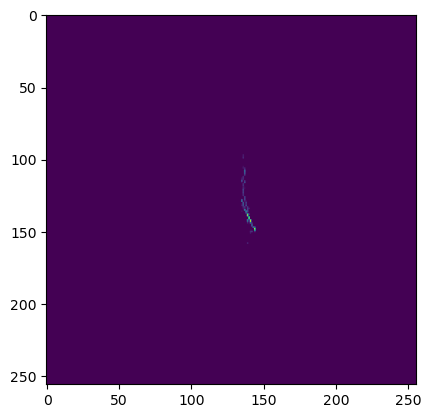

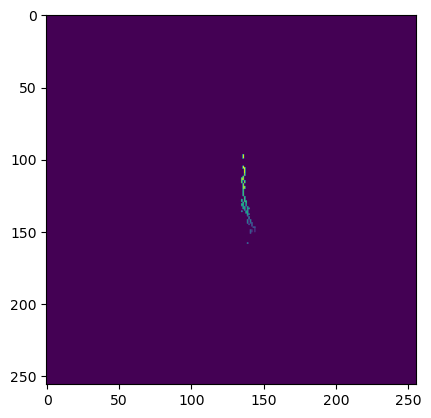

In [7]:
e = 36
with open(f"Accel/Pass1/ImagesV/Hits/Image_{e}.npz", 'rb') as file:
    check = np.load(file)['arr_0']
plt.imshow(check)
plt.show()
with open(f"Accel/Pass1/ImagesV/Truth/Image_{e}.npz", 'rb') as file:
    check = np.load(file)['arr_0']
plt.imshow(check)

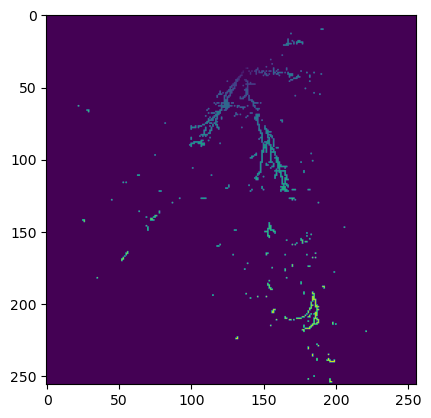

In [8]:
with open("Accel/Pass1/ImagesW/Truth/Image_14.npz", 'rb') as file:
    check = np.load(file)['arr_0']
plt.imshow(check)

In [17]:
view = "W"
vertex_pass=1
file_prefix = f"csv/DLUbooneTraining_Pass{vertex_pass}_CaloHitList"
image_size = (256, 256)
input_file = file_prefix + view + ".csv"

thresholds = [0., 0.00275, 0.00825, 0.01925, 0.03575, 0.05775, 0.08525, \
              0.12375, 0.15125, 0.20625, 0.26125, 0.31625, 0.42625]

with open(input_file, 'r') as f:
    reader = csv.reader(f)
    for i, row in enumerate(reader):
        data = row[1:-1]
        if i == 36:
            break

nv_coords = 2
nh_coords = 6
nuance = int(data.pop(0))
n_vertices = int(data.pop(0))

v_start, v_finish = 0, nv_coords * n_vertices
vx, vz = np.array(data[v_start:v_finish:2], dtype=float), np.array(data[v_start + 1:v_finish:2], dtype=float)
vertex = (vx[0], vz[0])

b_start = v_finish
x_min, x_max = float(data[b_start]), float(data[b_start + 1])
z_min, z_max = float(data[b_start + 2]), float(data[b_start + 3])

n_hits = int(data[b_start + 4])
h_start, h_finish = b_start + 5, b_start + 5 + nh_coords * n_hits
length = len(data[h_start:])

if length != (n_hits * nh_coords):
    print('Missing information in input file')
    print(n_hits, length)

hx = np.array(data[h_start:h_finish:nh_coords], dtype=float)
hz = np.array(data[h_start + 1:h_finish:nh_coords], dtype=float)
hadc = np.array(data[h_start + 2:h_finish:nh_coords], dtype=float)
hPdg = np.array(data[h_start + 3:h_finish:nh_coords], dtype=float)
hNuLike = np.array(data[h_start + 4:h_finish:nh_coords], dtype=float)
hCrLike = np.array(data[h_start + 5:h_finish:nh_coords], dtype=float)

image_height, image_width = image_size

# Update the span if image is too small
r_span = np.sqrt((x_max - x_min)**2 + (z_max - z_min)**2)

x_bins = np.linspace(x_min - 0.5 * drift_step, x_max + 0.5 * drift_step, image_width + 1)
z_bins = np.linspace(z_min - 0.5 * wire_pitch[view], z_max + 0.5 * wire_pitch[view], image_height + 1)

phx = np.digitize(hx, x_bins) - 1
phz = np.digitize(hz, z_bins) - 1
pha = np.digitize(hadc, z_bins) - 1

pvx = np.digitize(vertex[0], x_bins) - 1
pvz = np.digitize(vertex[1], z_bins) - 1

input_histogram, _, _ = np.histogram2d(hz, hx, bins=[z_bins, x_bins], weights=hadc)
input_histogram = input_histogram.astype(float)

input_nu_histogram = np.zeros_like(input_histogram)
input_nu_histogram = input_histogram.astype(float)

input_cr_histogram = np.zeros_like(input_histogram)
input_cr_histogram = input_histogram.astype(float)

# Fill both manually, we don't want any binning/averaging.
for i in range(len(phx)):
    input_nu_histogram[phz[i], phx[i]] = hNuLike[i]
    input_cr_histogram[phz[i], phx[i]] = hCrLike[i]

input_class_histogram, _, _ = np.histogram2d(hz, hx, bins=[z_bins, x_bins], weights=hPdg)
input_class_histogram = input_class_histogram.astype(float)

# ATTN: Need to set the dtype here or truth will be of type 8-bit uint before scaling, which will result in
# incorrect distances for dr > 255
truth_histogram = np.zeros_like(input_histogram, dtype=float)

# Handle case where vertex is outside of the hit bounding box. Note, it may still be possible for the correction
# to move the vertex outside the bounding box in the opposite direction (unlikely, but think about it)
# other way to do this is to bound the image including the vertex location
if pvx < 0: # underflow
    pvx = -(np.digitize(x_bins[0] + (x_bins[0] - vertex[0]), x_bins) - 1)
elif pvx >= (len(x_bins) - 1): # overflow
    pvx = np.digitize(x_bins[-1] - (vertex[0] - x_bins[-1]), x_bins) - 1
if pvz < 0: # underflow
    pvz = -(np.digitize(z_bins[0] + (z_bins[0] - vertex[1]), z_bins) - 1)
elif pvz >= (len(z_bins) - 1): # overflow
    pvz = np.digitize(z_bins[-1] - (vertex[1] - z_bins[-1]), z_bins) - 1

dr = np.sqrt((phx - pvx)**2 + (phz - pvz)**2)
class_histogram = np.zeros_like(truth_histogram)

for i in range(len(phx)):
    truth_histogram[phz[i], phx[i]] = dr[i]

truth_min, truth_max = np.min(truth_histogram), np.max(truth_histogram)

if truth_max > truth_min:
    truth_histogram = (truth_histogram - truth_min) / np.ceil(np.sqrt(2*(image_height - 1)**2))
    for i in range(len(phx)):
        cls = np.digitize(truth_histogram[phz[i], phx[i]], thresholds)

        #class_histogram[phz[i], phx[i]] = cls if cls < len(thresholds) else len(thresholds) - 1

        if input_cr_histogram[phz[i], phx[i]] > 0.60:
            class_histogram[phz[i], phx[i]] = 0
            input_histogram[phz[i], phx[i]] = 0
        elif input_class_histogram[phz[i], phx[i]] == 0:
            class_histogram[phz[i], phx[i]] = len(thresholds)
        elif cls < len(thresholds):
            class_histogram[phz[i], phx[i]] = cls
        else:
            class_histogram[phz[i], phx[i]] = len(thresholds) - 1
else:
    class_histogram = np.zeros_like(input_histogram)
class_histogram = class_histogram.astype(np.uint8)

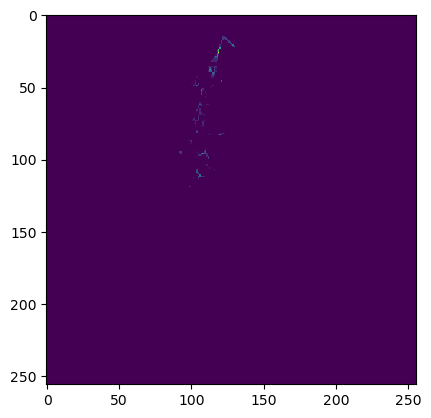

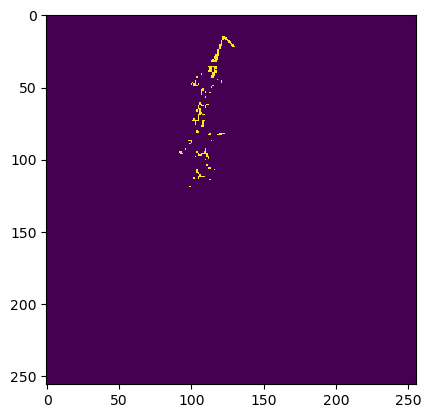

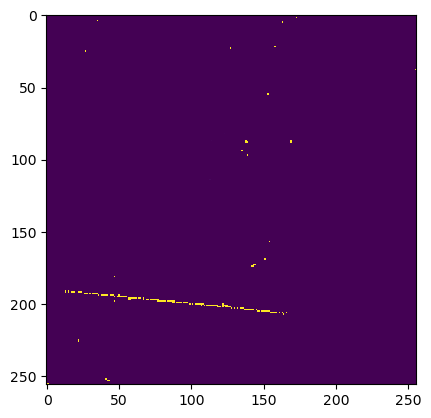

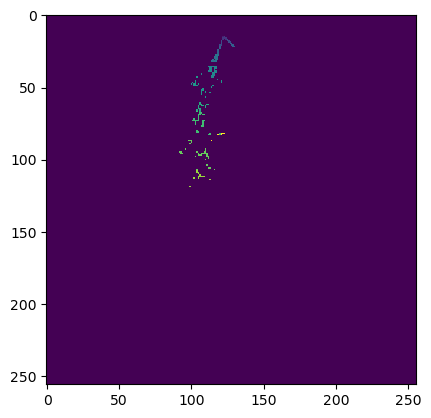

[ 0  1  2  3  4  5  6  7  8  9 10 11 13]
[   0.   11. 2212.]


In [18]:
plt.imshow(input_histogram)
plt.show()
plt.imshow(input_nu_histogram)
plt.show()
plt.imshow(input_cr_histogram)
plt.show()
plt.imshow(class_histogram)
plt.show()
print(np.unique(class_histogram))
print(np.unique(hPdg))

In [70]:
i = 17
with open(f"Accel/Pass1/ImagesW/Hits/Image_{i}.npz", 'rb') as file:
    check = np.load(file)['arr_0']
plt.imshow(check)
plt.show()
with open(f"Accel/Pass1/ImagesW/Truth/Image_{i}.npz", 'rb') as file:
    check = np.load(file)['arr_0']
plt.imshow(check)

FileNotFoundError: [Errno 2] No such file or directory: 'Accel/Pass1/ImagesW/Hits/Image_17.npz'